## Housing, Health & Happiness - Creative Extension

### I. Importing Libraries and Data

In [3]:
### Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas.util.testing as tm
import seaborn as sns

### Import data

DATA_FOLDER = '../Data/114542-V1/'

# NaN values are replaced with 0, as described in the paper

household_data = pd.read_stata(DATA_FOLDER + 'PisoFirme_AEJPol-20070024_household.dta').fillna(0)
individual_data = pd.read_stata(DATA_FOLDER + 'PisoFirme_AEJPol-20070024_individual.dta').fillna(0)

### II. Is the original matching truly balanced ? 

> In the paper 'Housing, Health, and Happiness', the treatment and control group are matched according to the variables C_blockdirtfloor, C_HHdirtfloor, C_child05 and C_households. The paper claims that these 4 variables are balances, according to Table 2 where the means for treatment and control are computed, along with standard errors and the mean difference. Let us verify with statistical tests that this is indeed the case.  

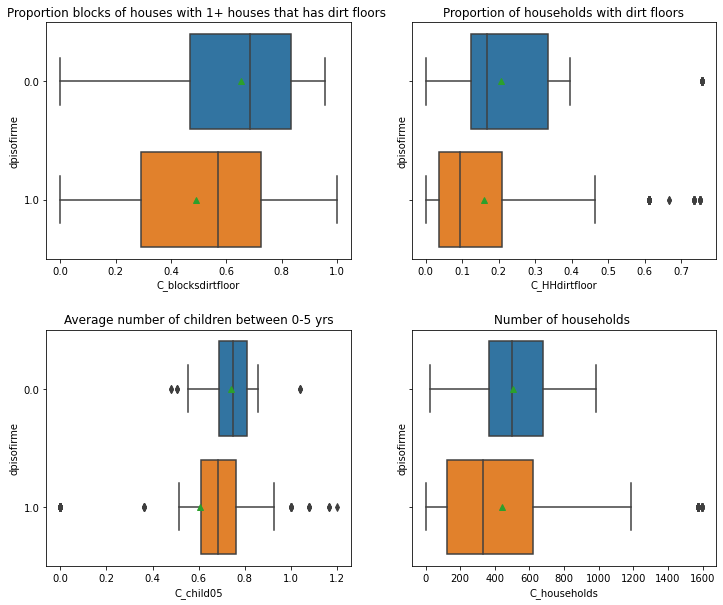

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
fig.subplots_adjust(hspace=0.3)

sns.boxplot(ax=axes[0,0], x=household_data['C_blocksdirtfloor'], y=household_data['dpisofirme'], showmeans=True, orient='h');
axes[0,0].set_title('Proportion blocks of houses with 1+ houses that has dirt floors ')

sns.boxplot(ax=axes[0,1], x=household_data['C_HHdirtfloor'], y=household_data['dpisofirme'], showmeans=True, orient='h');
axes[0,1].set_title('Proportion of households with dirt floors');

sns.boxplot(ax=axes[1,0], x=household_data['C_child05'], y=household_data['dpisofirme'], showmeans=True, orient='h');
axes[1,0].set_title('Average number of children between 0-5 yrs');

sns.boxplot(ax=axes[1,1], x=household_data['C_households'], y=household_data['dpisofirme'], showmeans=True, orient='h');
axes[1,1].set_title('Number of households ');

In [82]:
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import levene
from scipy.stats import ttest_ind

# Levene test verifies the null hypothesis that all input samples are from populations 
# with equal variances.

# The t-test verifies the null hypothesis that 2 independent samples have identical average 
# (expected) values. 
# This test assumes that the populations have identical variances by default, but we define 
# as False if the variances are not equal (known as Welch's t-test). 

df = pd.DataFrame(columns = household_data.columns).reset_index()
df['index'] = ['Levene test', 'Welch\'s T-test', 'Identical Mean']

for col in household_data:
    
    a = household_data[col][household_data['dpisofirme'] == 1]
    b = household_data[col][household_data['dpisofirme'] == 0]
    ltest = levene(a,b)
    if (ltest.pvalue < 0.05):
        ttest = ttest_ind(a, b, equal_var = False)
    else:
        ttest = ttest_ind(a, b, equal_var = True)
    if (ttest.pvalue < 0.05):
        identical_mean = False
    else:
        identical_mean = True
        
    df[col] = pd.Series([ltest.pvalue, ttest.pvalue, identical_mean])
    
df = df.drop(df.columns[[1, 2, 3, 4, 5, 6]], axis = 1)
df

,index,C_blocksdirtfloor,C_HHdirtfloor,C_child05,C_households,C_people,C_rooms,C_HHpersons,C_waterland,C_waterhouse,...,S_cesds,S_pss,S_instcement,S_instsanita,S_restsanita,S_constceili,S_restowalls,S_improveany,S_logrent,S_logsell
0,Levene test,9.0022e-11,5.83216e-07,5.74652e-54,7.59861e-48,5.51288e-51,1.66479e-56,7.68885e-29,3.90446e-07,6.45777e-30,...,4.44612e-06,0.0443939,1.83716e-118,0.121114,0.862713,0.0479416,0.305971,0.00924005,0.158063,0.00440933
1,Welch's T-test,9.23114e-59,2.61327e-15,4.2026e-63,3.09599e-07,7.75822e-09,4.14314e-24,1.5685e-69,2.58534e-09,0.42942,...,5.28233e-11,5.08303e-11,4.18925e-116,0.121114,0.862713,0.0479576,0.305971,0.00924342,0.0132806,0.0180526
2,Identical Mean,False,False,False,False,False,False,False,False,True,...,False,False,False,True,True,False,True,False,False,False


> It appears that the mean values for the 4 variables used for the matching are not balanced, as the statistical test yields a p-value below the threshold of 0.05, indicating that we must reject the null hypothesis of equal averages.

### III. Propensity score matching
> To remedy the matching issues, one can use the propensity score in order to match treatment and control groups.

In [5]:
### Defining the formulas for the regression models (LHS and RHS)

# LHS represents the 5 studied variables

mod_formula_lhs = ['S_shcementfloor', 'S_cementfloorkit', 'S_cementfloordin', 'S_cementfloorbat', 'S_cementfloorbed']

# RHS represents the control variables for the 3 models
  # Model 1: no controls
  # Model 2: age, demographic, health habits controls
  # Model 3: age, demographic, health habits, and public social programs controls

mod_formula_rhs = ['C(dpisofirme)', 'C(dpisofirme) + S_HHpeople + S_headage + S_spouseage + \
                     S_headeduc + S_spouseeduc + S_dem1 + S_dem2 + S_dem3 + S_dem4 + S_dem5 + S_dem6 + S_dem7 \
                     + S_dem8 + C(S_waterland) + C(S_waterhouse) + C(S_electricity) + C(S_hasanimals) + \
                     C(S_animalsinside) + C(S_garbage) + S_washhands', 'C(dpisofirme) + S_HHpeople + S_headage + S_spouseage + \
                     S_headeduc + S_spouseeduc + S_dem1 + S_dem2 + S_dem3 + S_dem4 + S_dem5 + S_dem6 + S_dem7 \
                     + S_dem8 + C(S_waterland) + C(S_waterhouse) + C(S_electricity) + C(S_hasanimals) + \
                     C(S_animalsinside) + C(S_garbage) + S_washhands + S_cashtransfers + C(S_milkprogram) +\
                     C(S_foodprogram) + C(S_seguropopular)'] 

# N.B. : the variable S_rooms is not included (number of rooms in the house), as it was not included in the Stata code
# provided. The variable is said to be used in the Models 2 and 3 in the paper, but the regressions yield better results
# in terms of replication when it is not included. 

In [11]:
### Declare Model

mod = smf.logit(formula = 'dpisofirme ~ S_shcementfloor + S_cementfloorkit + \
            S_cementfloordin + S_cementfloorbat + S_cementfloorbed', data=household_data)
# Ici j'aurais pluôt utilisé une regression logistique. 
# Je pense que idéalement, on devrait utiliser tous les paramètres pour prédire treatment.

### Fit Model

# np.random.seed(2)
res = mod.fit()

### Propensity score

household_data['Propensity_score'] = res.predict()   

Optimization terminated successfully.
         Current function value: 0.614840
         Iterations 6


In [12]:
len(household_data['Propensity_score'].unique())

94

In [13]:
household_data.head(3)

,dpisofirme,idcluster,coord_x,coord_y,idmun,idmza,C_blocksdirtfloor,C_HHdirtfloor,C_child05,C_households,...,S_pss,S_instcement,S_instsanita,S_restsanita,S_constceili,S_restowalls,S_improveany,S_logrent,S_logsell,Propensity_score
0,0.0,70000537.0,-103.50367,25.583067,7.0,40,0.3,0.036629,0.555554,819.0,...,12.0,0.0,0.0,0.0,0.0,0.0,0.0,5.298317,9.903487,0.330458
1,0.0,70000537.0,-103.50367,25.583067,7.0,40,0.3,0.036629,0.555554,819.0,...,24.0,0.0,0.0,0.0,0.0,0.0,0.0,5.298317,9.615806,0.601585
2,0.0,70000537.0,-103.50367,25.583067,7.0,40,0.3,0.036629,0.555554,819.0,...,16.0,0.0,0.0,0.0,0.0,0.0,0.0,6.214608,10.819778,0.601585
